# Homework: Compare Two Logistic Regression Models (Weather & Climate)

**Compare the performance of two logistic regression models**  
- **Model A (Full):** `CAPE`, `PWAT`, `Shear`  
- **Model B (Reduced):** `CAPE`, only

Does the three parameter model work better than the one parameter model?

**Tasks**
1. Split data into train/test.
2. Fit both models.
3. Compute **accuracy**, **precision**, **recall** at threshold 0.5.
4. Plot **ROC** and **Precision–Recall** curves for both models on the same figures.
5. Answer the interpretation questions.


In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             RocCurveDisplay, PrecisionRecallDisplay)

FEATURES_FULL = ['cape','pwat','shear']
FEATURES_REDUCED = ['cape']
TARGET = 'event'

# Synthetic fallback
USE_SYNTHETIC = True

if USE_SYNTHETIC:
    rng = np.random.default_rng(42)
    n = 1200
    cape  = rng.gamma(5.0, 250.0, size=n)
    pwat  = rng.normal(30, 8, size=n).clip(5, 70)
    shear = rng.normal(15, 6, size=n).clip(0, 40)
    z = -6.0 + 0.0025*cape + 0.06*pwat + 0.05*shear + 0.00002*cape*shear
    p = 1/(1+np.exp(-z))
    y = rng.binomial(1, p)
    df = pd.DataFrame({'cape':cape, 'pwat':pwat, 'shear':shear, 'event':y})
else:
    df = pd.read_csv('../data/your_data.csv').dropna()
    assert TARGET in df.columns
    assert all(c in df.columns for c in FEATURES_FULL)
    df = df[FEATURES_FULL + [TARGET]]
df.head()

,cape,pwat,shear,event
0,1339.091679,24.846334,4.350342,1
1,1620.699558,34.709626,23.376549,1
2,1237.079261,26.431445,20.809474,1
3,1157.616507,37.841527,29.506833,1
4,1708.955858,32.249385,6.662860,1


## 1) Train/Test Split

In [3]:
# TODO: Split into train/test for both feature sets using SAME random_state and stratify by y
X_full = df[FEATURES_FULL].values
X_reduced = df[FEATURES_REDUCED].values
y = df[TARGET].values.astype(int)

# YOUR CODE HERE
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full, y, test_size=0.25, random_state=0, stratify=y)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reduced, y, test_size=0.25, random_state=0, stratify=y)

len(Xf_train), len(Xf_test)

(900, 300)

## 2) Fit Both Logistic Regression Models

In [ ]:
# TODO: Fit two LogisticRegression models (full and reduced). Use max_iter >= 200.
# YOUR CODE HERE
clf_full = LogisticRegression(max_iter=200).fit(Xf_train, yf_train)
clf_reduced = LogisticRegression(max_iter=200).fit(Xr_train, yr_train)

yprob_full = clf_full.predict_proba(Xf_test)[:,1]
yprob_reduced = clf_reduced.predict_proba(Xr_test)[:,1]

clf_full.coef_, clf_reduced.coef_


Full test set size: 300
Reduced test set size: 300


## 3) Metrics at Threshold 0.5

In [9]:
thr = 0.5
ypred_full = (yprob_full >= thr).astype(int)
ypred_reduced = (yprob_reduced >= thr).astype(int)

# TODO: Compute Accuracy, Precision, Recall for both models at threshold 0.5
acc_f = accuracy_score(yf_test, ypred_full)
prec_f = precision_score(yf_test, ypred_full, zero_division=0)
rec_f = recall_score(yf_test, ypred_full, zero_division=0)
print(f"Accuracy (Full):  {acc_f:.3f}\nPrecision (Full): {prec_f:.3f}\nRecall (Full):    {rec_f:.3f}")

acc_r = accuracy_score(yr_test, ypred_reduced)
prec_r = precision_score(yr_test, ypred_reduced, zero_division=0)
rec_r = recall_score(yr_test, ypred_reduced, zero_division=0)
print(f"Accuracy (Reduced):  {acc_r:.3f}\nPrecision (Reduced): {prec_r:.3f}\nRecall (Reduced):    {rec_f:.3f}")

Accuracy (Full):  0.723
Precision (Full): 0.733
Recall (Full):    0.678
Accuracy (Reduced):  0.717
Precision (Reduced): 0.736
Recall (Reduced):    0.678


## 4) Plot ROC and Precision–Recall Curves

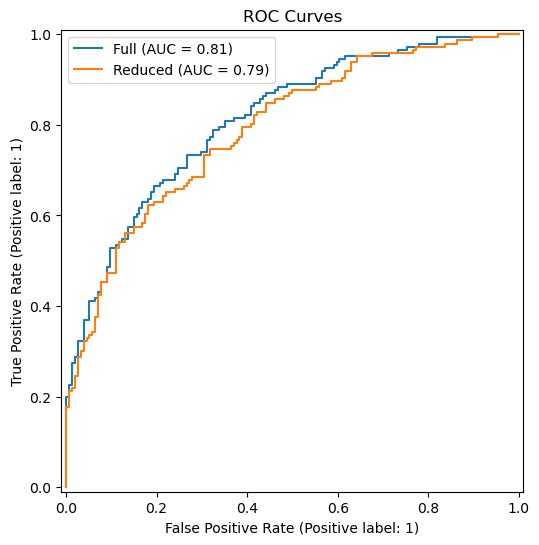

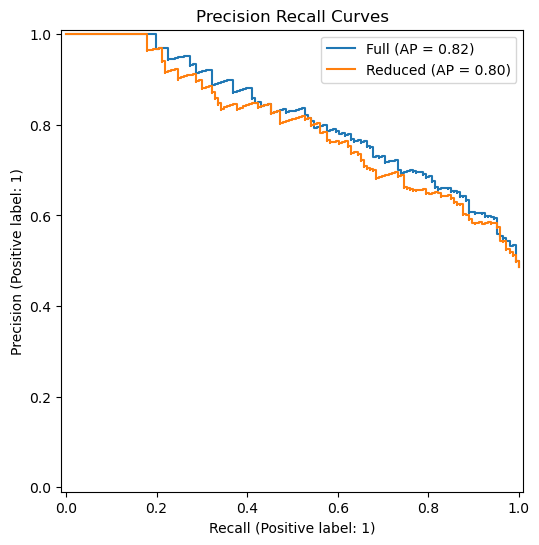

In [17]:
# TODO: Plot ROC and PR curves for both models on shared axes
fig, ax = plt.subplots(figsize=(6, 6))
RocCurveDisplay.from_predictions(yf_test, yprob_full, name="Full", ax=ax)
RocCurveDisplay.from_predictions(yr_test, yprob_reduced, name="Reduced", ax=ax)
ax.set_title("ROC Curves")
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(6, 6))
PrecisionRecallDisplay.from_predictions(yf_test, yprob_full, name="Full", ax=ax)
PrecisionRecallDisplay.from_predictions(yr_test, yprob_reduced, name="Reduced", ax=ax)
ax.set_title("Precision Recall Curves")
ax.legend()
plt.show()


## 5) Interpretation

1. Which model has higher **ROC-AUC** and **PR-AUC**? What does this imply about `PWAT`?  
2. Compare **accuracy**, **precision**, and **recall** for both models.  
   - Which model would you choose to **maximize event detection** (recall)?  
   - Which model would you choose to **minimize false alarms** (precision)?  

1) Model A (full) has slightly higher ROC-AUC (0.81) and PR-AUC (0.82) compared to the Model B's ROC-AUC (0.79) and PR-AUC (0.80). This suggests that the inclusion of PWAT (and shear?) improves performance of the model and it contributes meaningful information for predictions.

2) Model A (full) achieved slightly higher accuracy (0.723 vs. 0.717),but slightly lower precision (0.733 vs. 0.736) compared to Model B (reduced). The recall of both models was identical (0.678).

To maximize event detection, I would choose the model with higher recall. The models performed equally at recall, so either works.
To minimize false alarms, I would choose the model with higher precision. This is Model B (reduced).



Data copied from above:
_______________________
Accuracy (Full):  0.723
Precision (Full): 0.733
Recall (Full):    0.678
Accuracy (Reduced):  0.717
Precision (Reduced): 0.736
Recall (Reduced):    0.678